# Workshop 2 - Developing and Assessing Quantitative Structure Activity Relationship Machine Learnt Models

<strong>Author(s):</strong> Neil Berry, based on work from Jessica A. Nash, The Molecular Sciences Software Institute (https://github.com/MolSSI-Education/) and Dr Sam Chong (https://github.com/drsamchong)

## Learning Objectives
- Learn how molecules can be represented in a machine readable format
- Generate a cheminformatics data set using the RDKit library starting from a list of SMILES codes
- Perform Exploratory Data Analysis
- Prepare the data
- Create and train a linear regression model
- Create and train a random forest regression model
- Compare the performance between the models
- Tune a random forest model for optimal performance 


### Machine learning (ML)

ML can be applied for (text adapted from [scikit-learn page](http://scikit-learn.org/stable/)):

* **Regression**: Prediction of a continuous-values attribute associated with an object - see below
* Classification (supervised): Identify which category an object belongs to - see Workshop 3
* Clustering (unsupervised): Automated grouping of similar objects into sets - not covered in this course

## Theory

To successfully apply ML, we need a large data set of molecules, a molecular encoding, a label per molecule in the data set, and a ML algorithm to train a model. Then, we can make predictions for new molecules.

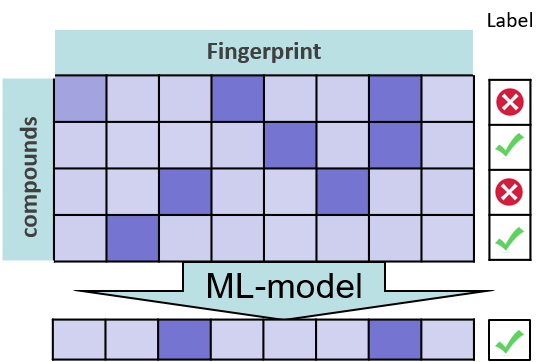

_Figure 1_: Machine learning overview: Molecular encoding, label, ML algorithm, prediction. Figure by Andrea Volkamer.

### Importing libraries

In [1]:
# If you do not have scikit-learn installed, uncomment the following line
# !conda install -y -c conda-forge scikit-learn

In [2]:
import pandas as pd                 # for data manipulation
import seaborn as sns               # for data visualization
import matplotlib.pyplot as plt     # for data visualization
import numpy as np                  # for numerical operations

from rdkit import Chem              # for calculating cheminformatics properties of molecules
from rdkit.Chem import Descriptors  # for determining chemical descriptors
from rdkit.Chem import Crippen      # for calculating logP (cLogP)
from rdkit.Chem import PandasTools  # for displaying molecules
PandasTools.RenderImagesInAllDataFrames(images=True) # Ensures molecules are rendered in the notebook
PandasTools.RenderImagesInAllDataFrames()

from sklearn.preprocessing import StandardScaler            # for scaling the data
from sklearn.model_selection import train_test_split        # for splitting the data into training and testing sets
from sklearn.dummy import DummyRegressor                    # for creating a dummy regression
from sklearn.linear_model import LinearRegression           # for creating a linear regression model
from sklearn.ensemble import RandomForestRegressor          # for creating a random forest regression model
from sklearn.metrics import mean_squared_error, r2_score    # for evaluating the model
from sklearn.pipeline import make_pipeline                  # for building operational pipelines

<div class="alert alert-block alert-info">
    <b>Note</b>
    We have added comments to clarify the purpose of each imported library - please take note. You will be using many of these again.
</div>

## Problem Statement

In this notebook, we will be **creating a cheminformatics data set** from a machine-readable list of molecules. The goal is to use the provided molecules to calculate various chemical properties of each molecule and then predict the solubility of a molecule base on its chemical structure using machine learning models. We will create a version of the [Delaney's solubility dataset](https://doi.org/10.1021/ci034243x).  We will then use this data set for **building both Linear and Random Forest regression models** and compare their  performance. 

#### Steps

1. Load the data
2. Calculate descriptors
3. Perform some EDA to gain initial understanding of the distribution of features and relationships between features, and with the target.

For each model (may require additional stages depending on the model)

4. Prepare the data 
5. Train the model
6. Make predictions
7. Evaluate performance
8. Analyse the performance of the models. Draw conclusions about the chemical problem.

# RDKit 

Reminder:

There are Python libraries that are made for working just with chemical data. One commonly used library in Python for cheminformatics is called [RDKit](https://en.wikipedia.org/wiki/RDKit). RDKit is an open-source cheminformatics library, primarily developed in C++ and has been under development since the year 2000. We will be using the Python interface to RDKit, though there are interfaces in other languages. We used RDKit in the first workshop.

RDKit provides a molecule object that allows you to manipulate chemical structures. It has capabilities for reading and writing molecular file formats, calculating molecular properties, and performing substructure searches. In addition, it offers a wide range of cheminformatics algorithms such as molecular fingerprint generation, similarity metrics calculation, and molecular descriptor computation. This notebook introduces RDKit basics.

<div class="alert alert-block alert-success"> 
<strong>Python Skills: Python Objects</strong>

Most of this functionality is achieved through the RDKit `mol` object. In Python, we use the word "object" to refer to a variable type with associated data and methods. 
One example of an object we have seen in notebooks is a list - we could also call it a "list object". An object has `attributes` (data) and `methods`. 
You access information about objects with the syntax
```python
object.data
```
where data is the attribute name.

You access object methods with the syntax
```python
object.method(arguments)
```
</div>    

We will create and manipulate RDKit `mol` objects. RDKit `mol` objects represent molecules and have attributes (data) and methods (actions) associated with molecules.

We are going to use a part of RDKit called `Chem`. To use `Chem` we have to import it, which we did above in the importing libraries section. 

### Machine learning (ML)

ML can be applied for (text adapted from [scikit-learn page](http://scikit-learn.org/stable/)):

* **Regression**: Prediction of a continuous-values attribute associated with an object - see below
* Classification (supervised): Identify which category an object belongs to - see notebook 3
* Clustering (unsupervised): Automated grouping of similar objects into sets - not covered in this course

### The original data set

Let's load the list of molecules using the ``pandas`` library 
and take a look at a few samples in the dataset

In [ ]:
# TO DO Change the data_path variable to the location of solubility-molecule-list.csv 
# Path to the list of molecules data file
data_path = ""

# Read the data into a DataFrame
df = pd.read_csv(data_path)

# TO DO Type 10 in the brackets in the command below to see the top 10 lines in the file
# Display the first few rows of the DataFrame
df.head()

The dataset contains the following columns:
- **Compound ID**: compound name in a range of formats
- **smiles**: SMILES string representation of each molecule
- **logS**: the solubility of the molecule in mol/L measured at 25 $\degree$ 𝐶

### Adding molecule structures to the data set using the SMILES strings

Above we werer reminded about molecular representations using SMILES strings. Now we will use SMILES strings to create molecule objects in RDKit. 

We can create a representation of methane using RDKit by using the `MolFromSmiles` function in `rdkit.Chem`.

In [ ]:
# visualizing methane as an example
methane = Chem.MolFromSmiles("C")
methane

In [ ]:
# TO DO Type CCC in between the "" in the command below
# visualizing propane as another example
propane = Chem.MolFromSmiles("")
propane

### The `.apply` function

In the examples above, we made a single molecule object from a single SMILES string.  However, when we are working with a lot of data, we might have a whole column of SMILES strings that we need to use to make molecule objects.  Further, we would like to save those molecule objects as a new column in our pandas dataframe.  This is generally true; you often want to calculate a new column of data using an existing column in your data frame.  The way to accomplish this is to use the `.apply` method.  You access any exisiting column of your python dataframe, put `.apply()` and then in the parenthesis, list a python function that calculates the thing you want to calculate.  In the code below, we will take the column of SMILES strings and apply the `Chem.MolFromSmiles` function and save the results as a new column of the dataframe.

In [ ]:
# TO DO Insert Chem.MolFromSmiles in the brackets below
# visualizing all the molecules in our data set
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df.head()

# If you can not see a rendering of the molecule in the mol column, click on the three dots on left hand side and select "change presentation" and select "text/html" from top of the screen

RDKit molecule objects have a number of methods we can use to get more information about the molecule. In the next few cells, we'll look at some methods that can tell us some things about the molecules we've created.  

We can use the `.apply` function that we just discussed to apply these methods to our molecule objects and save the results in a new column.

### Calculating Molecular Weights

In [ ]:
df['mol_weight'] =df['mol'].apply(Descriptors.MolWt)
df.head()

### Calculating number of rotatable bonds

In [ ]:
# TO DO Find a function which can calculate the number of rotable bonds after the Chem.rdMolDescriptors. below
df['rot_bonds'] =df['mol'].apply(Chem.rdMolDescriptors)
df.head()

### Calculating logP

This uses the Wildman-Crippen LogP value calculation, an atom-based scheme based on the values in the paper Wildman and G. M. Crippen JCICS 39 868-873 (1999) (https://pubs.acs.org/doi/10.1021/ci990307l)

In [ ]:
df['clogP'] =df['mol'].apply(Chem.Crippen.MolLogP)
df.head()

### Calculating aromatic ratio

The aromatic proportion was calculated in the original paper by dividing the number of aromatic atoms by the number of total atoms. Although there is not a function in RDKit that calculates this directly, we can calculate it by creating our own function that uses two existing RDKit functions to perform the calculation. Then we can use our new function and ``.apply`` to make a new column in our data set.

In [10]:
## defining the function that will calculate the aromatic proportion
def aromatic_calc(mol):
    prop_aromatic = len(mol.GetAromaticAtoms())/mol.GetNumAtoms()
    return prop_aromatic

In [ ]:
# TO DO Insert aromatic_calc in the brackets below
df['aromatic_ratio'] =df['mol'].apply(aromatic_calc)
df.head()

### Other calculations RDKit can perform

There are many other properties of molecules that RDKit can caculate.  In general, the methods in RDKit are organized into modules baesd on the type of property they calculate.  For instance, in some of the examples above, we used methods from the 
[`Descriptors` module](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html) and the [`rdMolDescriptors` module](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html).  You can click on either of those links to see the full list of the different properties you can access. 

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    Look through the documentation and the molecular properties you could
    to add to your dataframe. 
</div>

### Exploratory Data Analysis (EDA) of the data set

The next step after stating the problem and compiling the raw data is to perform exploratory data analysis (EDA) on raw data. The EDA is crucial for data preprocessing pipelines as it helps us understand the nature of our data, identify the key patterns and relationships, and detect anomalies. The EDA involves summarizing the main characteristics of the data, often using visual methods. 

Loading the data into a Pandas DataFrame provides a convenient way to perform EDA.

In addition to looking for distribution and patterns in the data, look at what the columns actually contain. Some may include metadata about the source of the observation and its processing, which will not be relevant to the target variable, i.e. "Compound ID", "smiles" and "mol".

In [ ]:
# TO DO Type in df.info() below 
#Display informaion about the data


There are 1128 samples in the dataset with 6 columns and there appear to be no missing values.

Each row corresponds to a compound. Two columns a contain identifier and molecular string representations.

It is important to check any available documentation when you are working with a dataset that you have not compiled yourself. 
The AqSolDB paper/docs provide information about the dataset, such as which columns contain metadata regarding the source or processing of the data, the form of the quoted solubility values.

The **target variable** is contained in the `logS` column. The paper tells us that this is a logS value, where S is the aqueous solubility in mol L<sup>-1</sup>.

The majority of numerical columns are molecular descriptors.

You should have some understanding of the nature of some features simply by looking at the names, e.g. (`mol_weight`, `rot_bonds`, etc.).


### Checking for Missing Values

Since the data is already preprocessed, the number of Missing values for all features should be zero. The experimentally measured solubility in the last column logS is the target variable and the remaining columns are the features.

<div class="alert alert-block alert-success"> 
    <b>Note</b>
    Always check for missing values in the data sets that you look at.
</div>

### Statistical Summary of the Data
We should also examine the statistical summary of each numerical features in our dataset. The  statistics include the value counts, mean, standard deviation, minimum, 25th percentile, median, average, 75th percentile, and maximum values for each feature.

This information is extremely useful for understanding the data and the distribution of the features. It helps in identifying anomalies in the data or if our data requires any preprocessing. 

In [ ]:
# Describe dataset - we first create a new dataframe just with the numerical data dropping metadata
df_data = df.drop(columns = ['Compound ID','smiles','mol'])
df_data.describe()

The summary statistics provide an overivew. There are a few points to note:

1. Looking just at the mean (or median, the 50% percentile), the scale of the variables are quite different: e.g. clogP has a mean of 2.44 vs. mol_weight mean of 203.
   
2. The spread of values, indicated by the standard deviation and range, are also highly varied between variables.
   
3. The target variable (logS) has a negative mean and median, but the range extends into positive values.
   
4. Several variables have marked differences between the mean and median. From the summary statistics alone, you cannot definitively tell what is causing this. If you assume the distribution is unimodal, a difference between mean and median often points to asymmetry (skewness), and you could deduce the likely direction of the skew. However, the difference could also be caused by a multimodal distribution or the influence of outliers. Visualising the variable’s distribution would be a sensible step to explore this further.
   
5. The min and/or max values of several variables are far from the mean or median which may indicate that they are outliers. Again, visualisation of the distributions would provide more insight.
   
6. It is not the case here, but if a variable has a very small standard deviation, it suggests that it may be almost constant across the dataset. This might indicate low variability (which could be natural for some properties) or that a variable was not meaningfully measured. It is worth checking if any variables do have low variance, as they may contribute limited useful information to the analysis and could potentially be removed later. To explore this in more detail, you can scale the data and check for low variance/std deviation across the variables.
   


##### Distributions of individual variables (univariate distributions)

Visualising the distributions of variables is often the most straightforward way to get an initial assessment of the [shape](https://www.statsref.com/HTML/index.html?measures_of_distribution_shape.html) of an individual variable's distribution, but there are some numerical measures that can also provide an indication.

### Skewness and Kurtosis
The [`skewness`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html)  of the data, which is determined by comparing the mean and median values, should be looked at.

The numerical values of skewness can be interpreted using the following rules:
- The skewness value of zero indicates a perfect symmetrical distribution,
- a skewness between -0.5 and 0.5 indicates an approximately symmetric distribution,
- a skewness between -1 and -0.5 (or 0.5 and 1) indicates a moderately skewed distribution,
- a skewness between -1.5 and -1 (or 1 and 1.5) indicates a highly skewed distribution, and
- a skewness less than -1.5 (or greater than 1.5) indicates an extremely skewed distribution.

<div class="alert alert-block alert-success"> 
    <b>Note</b>
    Which descriptors have high or extremely skewed distributions.
</div>

In [ ]:
df_data.skew(axis=0)


The [`kurt`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurt.html) method gives a measure of the "tailedness" - how heavy the tails of the distribution of a set of values (the opposite is "peakedness"). 

It uses the Fisher definition where a value of 0 indicates a normal distribution, while a positive value indicates a distribution with heavier tails (flatter peak) and a negative value indicates a distribution with lighter tails (sharper peak).

In [ ]:
df_data.kurt(axis=0)

In [ ]:
# Initial visualisation of the distributions of features
n_cols = 4  
n_rows = (len(df_data.columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Flatten the axes array to iterate easily
axes = axes.flatten()

for i, col in enumerate(df_data.columns):
    sns.histplot(df_data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

At this scale, it is rather difficult to see the individual distributions clearly, but it is obvious that some of variables have very long "tails", pointing to extreme values - which could be potential outliers - in the data.

For now, we can look more closely at the target variable. There are several possibilities, e.g. as a histogram, violinplot or boxplot:

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

sns.boxplot(y="logS", data=df_data, ax=axes[0])
sns.violinplot(y="logS", data=df_data, ax=axes[1])

axes[0].set_title('Box plot of Solubility values')
axes[1].set_title('Violin plot of Solubility values')

axes[0].set_ylabel('Solubility (log S)')

plt.tight_layout()
plt.show()

These visualisations emphasise different aspects of the distribution. 

The [histogram](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot) shows a detailed view of the frequency of subranges of the solubility values. It can be plotted with an overlaid line showing a [kernel density estimation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) (KDE) to provide a smoothed approximation of the underlying distribution (see also: [KDE pitfalls](https://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation-pitfalls) for why combining the two can be valuable).

The [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) makes it straightforward to see the quartiles of the distribution and therefore highlights the presence of extreme values, but without much detail of the underlying values.

The [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) combines the information of the boxplot with a KDE to show more detail of the underlying distribution.

The solubility distribution has a larger peak, centred around log S ≈ –2.5, with a shoulder at more negative values. This shows how visualisation can reveal important structure in the data that may not be apparent from simple summary statistics such as skewness. Recognising this complexity is important, as it may indicate the presence of subsets of compounds or differing underlying mechanisms that a single model might struggle to capture effectively.

Various features of the box-, and violinplots can be adjusted - see the documentation. They convey the information about a single variable's distribution in a compact form, so can be particularly useful to quickly do this for several variables at once.

##### Bivariate analysis - pairwise relationships

A correlation value close to 1 between a pair of descriptors indicates a strong positive relationship, while a correlation value close to -1 indicates a strong negative relationship. A correlation value close to 0 indicates no relationship between the features.

The coloring scheme makes it easy to uncover the relationships between the features. The darker the color, the stronger the correlation. The diagonal line represents the correlation of each feature with itself, which is always 1. The blue color indicates a positive correlation, while the red color signifies a negative correlation (based on the provided key).

In [ ]:
# TO DO Type in df_corr.corr() in line 3 below
# Caculate the correlation matrix - by default, this will use Pearson's correlation coefficient, r
corr = 
corr

In [ ]:
# Initial visualisation of the correlations between variables
plt.figure(figsize=(5, 5))

# Create a mask to hide the upper triangle - makes the heatmap easier to read
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, 
            annot=True, fmt=".2f", 
            cmap='coolwarm', 
            square=True,
            mask=mask, 
            cbar_kws={'label': 'Pearson correlation coefficient, r'})

plt.title('Correlation matrix of features')
plt.tight_layout()
plt.show()

The correlation matrix clearly shows strong bivariate relationships between several features. For example, the magnitude of the Pearson correlation coefficient is above 0.8 clogP and logS.

 Strongly correlated features are potential candidates for removal if you are considering reducing the number of features in your model (feature selection). This is because strongly correlated features contribute overlapping information, so including both can make one redundant. Using fewer features can improve the interpretability of the model and may also improve its performance by reducing overfitting.

Detecting strongly correlated features is particularly important in regression models, where high [multicollinearity](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/) (when two or more features are highly correlated) can cause problems. Multicollinearity makes it difficult to estimate the effect of each feature accurately and can lead to unstable or misleading model coefficients.

If you are using exploratory data analysis to guide feature selection, it is important to remember that this should be based only on the training data, not the full dataset. Using information from the test data at this stage would lead to data leakage, giving an unrealistically optimistic estimate of model performance. 

### Correlation of Features with Target Variable
The correlation matrix between the features and the target variable provides insights into the relationships between the features and the target variable(s). 

A correlation value close to 1 indicates a strong positive relationship, while a correlation value close to -1 indicates a strong negative relationship. A correlation value close to 0 indicates no relationship between the features.

The strongest correlation with the solubility values is with cLogP, indicated by a moderately negative Pearson correlation coefficient of -0.83. It makes sense that aqueous solubility and cLogP would be related and in the inverse direction.


In [ ]:
# Visualise relationships between features and target

n_cols = 4  
n_rows = (len(df_data.drop(columns=["logS"]).columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows), sharey=True)


# Flatten the axes array to iterate easily
axes = axes.flatten()

for i, col in enumerate(df_data.drop(columns=["logS"]).columns):

    # Use regplot to add a regression line to the scatter plot of target vs. feature
    sns.regplot(data=df_data, 
                x=col, 
                y="logS", 
                marker=".",
                ci=None,
                line_kws=dict(color="r", linewidth=1),
                scatter_kws=dict(alpha=0.5, linewidths=0.5),
                ax=axes[i])

    # You can also try to colour the points by another feature to see if there is a > bivariate relationship, e.g.:
    # sns.scatterplot(data=num_sol_df, x=col, y="Solubility", hue="HeavyAtomCount", ax=axes[i], palette="viridis")
    axes[i].set_title(f'Log S vs. {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Solubility (log S)')
    axes[i].set_ylim(df_data["logS"].min() - 1, df_data["logS"].max() + 1)


# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The plots also show that for some of the variables there is not a strong linear relationship between the descriptor and the compound solubility. This suggests that any dependence may be more complex: nonlinear, involving combinations of features, or conditional on particular regions of the data. For example, solubility might increase with molecular weight up to a point, but then decrease for very large molecules - a relationship that would not be captured well by a simple straight line. 

When linear relationships are weak, this can be one reason to explore nonlinear models or feature engineering to better capture patterns.

### Points to Remember:
  EDA can help to uncover initial information on:

   - Feature distributions
     - Check descriptive statistics  
     - mean, median, standard deviation, range, quartiles (e.g., using `df.describe()`)
   - Visualise using plots like
     - Histograms (shape, skewness, modality)
     - Box plots (spread, outliers)
     - KDE plots (smooth estimate of distribution shape)
    
   - Relationships between variables
     - Numerical summaries for multiple pairwise relationships
     - Correlation matrix (e.g., Pearson correlation coefficients)
   - Visualise using plots like
     - Scatter plots (direct relationships between two variables)
	  - Correlation heatmaps (summarising pairwise correlations visually)
  
   - Detecting outliers or unusual patterns
     - Look for
	   - Large differences between mean and median, extreme minimum or maximum values, unusually wide ranges.
   - Visualise using plots
     - Box plots (to highlight points outside the whiskers)
	   - Scatter plots (isolated points far from main clusters)
	   - Histograms/KDE plots (unexpected pronounced tails)

   - Checking for Redundancy and Multicollinearity
	   - Look for
	   - High correlation coefficients between features (e.g., > 0.9 or < -0.9).
	 - Visualise using plots
	   - Correlation heatmaps (visually detect highly correlated pairs).
	
   - Some modelling choices informed by EDA:
	    - Remove irrelevant metadata features
	    - Consider dropping or combining highly correlated features
	    - Highlight features with very low variance for possible removal

  Overall, EDA can provide information on the following questions:
   - Are there obvious problems with the data (outliers, skewed distributions) that might require addressing before modelling?
   - Which features might be the most informative or redundant?
   - What kind of models might work best (e.g., linear models vs. nonlinear models)?
   - How should the data be pre-processed before training models?

    EDA does not provide comprehensive answers from the data, but by exploring and gaining better understanding your data, it allows you to ask much better questions about your data, the features and about your modelling approach.

  
  - Some feature-to-feature linear correlations are present, indicated by the Pearson correlation coefficients and the bivariate scatterplots.

	- No single feature shows very strong correlation with the target; the strongest linear relationship between solubility and CLogP. Given that the solubility here is aqueous solubility (log S), the observed moderate negative correlation with MolLogP (the n-octane-water partition coefficient) would be chemically reasonable.
	
	- It is important to remember that a lack of strong linear correlation does not necessarily indicate there is no relationship: complex, nonlinear or interaction effects may exist.

	- Metadata features not chemically relevant to solubility (e.g., Occurrences, Group) should be removed.
	- Strongly correlated features might be candidates for removal. Strong correlations can mean that some variables do not contribute additional data, i.e. they are redundant. Removing redundant features can improve model interpretability and reduce risk of overfitting. 
	- Features with little variation (very low variance/standard deviation) would be considered for removal although none were found here. Again, this can enhance model interpretability and reduce model complexity.
	- Care must be taken to select features based only on training data to avoid data leakage.

- Note the distributions of values of features (e.g. the measures of centre, the magnitude and shape of the distribution and the range of the values).


## Splitting the Data Into Training and Testing Sets

Once we have a good understanding of the data, we can move on to the next step, which is splitting the data into a training set and a testing set. The training set is used to train the model, and the testing set is used to evaluate the model's performance. This process allows you to test the model's accuracy on unseen data and ensures that the model can generalize well to new data.

<div class="alert alert-block alert-info">
    <b>Note</b>
It is extremely important to split the data first and then perform subsequent feature engineering steps. Feature engineering prior to splitting the data can cause a <b>data leakage</b> problem, allowing the model to "see" the testing data in the training phase. This violates our intention to treat the test data as a good representative sample of the real-world data. Data leakage leads to a model that performs well in training and testing but that performs poorly when given novel data.
</div>

To create our training and testing data sets, we will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance.

Useful information about the train test split process:
- ``X`` generally denotes the input variables (the data the model will use to make predictions)
- ``y`` is often used for target variable (what we are trying to predict)
- ``test_size`` is used to assign the percentage of the data set aside for the testing set
- ``random_state`` controls the random number generator used to shuffle the data before splitting it. In other words, it ensures that the same randomization is used each time you run the code, resulting in the same splits of the data. This is especially useful if you want to compare the performance of multiple models
- ``shuffle = True`` ensures that the data is split randomly.

In [ ]:
# TO DO Add clogP in between the "" in line 4 and logS between '' in line 5 
# Create the feature matrix (X), feature vector (x), and the target vector (y)
X = df.drop(columns=['logS'])
x = X[""]
y = df['']

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

# Reshape the data into 2D arrays of shape (n_samples, 1)
# (if working with only one input feature)
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the use of the <b>x</b> vector in the <b>train_test_split</b> function as initially we will train a model using only one input feature <b>CLogP</b>.<br> If we instead want to use all the available features we would need to use the <b>X</b> matrix that we have defined.
</div>

<div class="alert alert-block alert-info">
    <b>Reminder:</b>
    It is extremely important to split the data first and then fit the scaler on the training data, only. Fitting the scaler on the entire data and then splitting it causes the <b>data leakage</b> problem which violates our intention to treat the test data as a good representative sample of the real-world data.  
</div>

## Feature Engineering

Once we have a good understanding of the data, we can move on to the next step, which is feature engineering. Feature engineering is the process of transforming the raw data into a format that is suitable for machine learning models. Feature engineering often involves creating new features, selecting the most important features, and transforming the existing features in order to improve the model's performance.

After splitting our data, we need to scale our train and test features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale, since many machine learning models are sensitive to the scale of the input features. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features. ``StandardScaler`` transforms the data in such a manner that it has mean value of 0 and a standard deviation value of 1.

In [ ]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector x_train
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test feature vector x_test
x_test_scaled = scaler.transform(x_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {x_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {x_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {x_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {x_test_scaled.std():.5f}")

## Building and Training a Linear Regression Model

The next step after the data preparation is to build and train our model. We will build a simple linear regression model which focuses on the relationship between a single feature (``CLogP``) and the target variable (``logS``). 

<div class="alert alert-block alert-success"> 
    <b>Consider</b>
    What is the reason behind choosing <b>CLogP</b> as our main feature in the linear regression model?
</div>

In order to evaluate the performance of our model, we can first create a dummy "model" using the ``DummyRegressor`` class from the ``sklearn.dummy`` module. This class provides a simple way to create a model that calculates the mean value of the target feature and predicts this mean value for each observation. The ``fit`` method is used to train the model on the training data. Once the model is trained, we can use the ``predict`` method to make predictions on the test data. Note that the ``DummyRegressor`` is not for solving real problems!

In [ ]:
# Create a dummy model using the mean value of the target property
dummy_model = DummyRegressor(strategy="mean")

# TO DO Add in y_train in the brack below after the comma
# Fit the model to the training data
dummy_model.fit(x_train_scaled, y_train)

# Make predictions on the testing data
y_pred_dummy = dummy_model.predict(x_test_scaled)

# Calculate the performance metrics and store them in a DataFrame
dummy_results = pd.DataFrame({
    "Coefficients": [np.array(dummy_model.constant_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_dummy),     # the mean squared error
    "R2": r2_score(y_test, y_pred_dummy)                 # the coefficient of determination
}, index=["Dummy"])
dummy_results

<div class="alert alert-block alert-success"> 
    <b>Consider</b>
    Do we want to maximize or minimize the MSE value? What about R2?
</div>

### Linear Regression Model

Let's next build and train a single-feature input linear regression model. We will use the ``LinearRegression`` class from the ``sklearn.linear_model`` module to create the model. 

In [ ]:
# Create a simple linear regression model
simple_reg_model = LinearRegression()

# Fit the model to the training data
simple_reg_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_simple = simple_reg_model.predict(x_test_scaled)

# Calculate the performance metrics
simple_model_results = pd.DataFrame({
    "Coefficients": [np.array(simple_reg_model.coef_)],   # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_simple),     # the mean squared error
    "R2": r2_score(y_test, y_pred_simple)                 # the coefficient of determination
}, index=["Simple-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([dummy_results, simple_model_results])
results

### Visualizing Model Performance

In [ ]:
# Create a plot object 
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(x_test_scaled, y_test, color='blue', label='Test Data')

# Plot the simple linear regression model
ax.plot(x_test_scaled, y_pred_simple, color='red', label='Simple Linear Regression')

# Plot the baseline model
ax.plot(x_test_scaled, y_pred_dummy, "g--", label="Dummy")

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

# Building a multifeature linear regression

We can improve our model by including other features that show some correlation with the target variable. This is where multiple linear regression comes in.

Let's build a multiple linear regression model using all the features in our dataset. The process is very similar to building a single-feature linear regression model: Once again, we need to scale the data, train the model on the scaled training data using the ``fit`` method, and make predictions on the test data using the ``predict`` function.

Linear regression models the relationship between input features and a continuous target variable using a linear function (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

The function looks like:  

$$
y = w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n + \epsilon
$$

Where:  
- $ y $ = **Predicted output** (target variable)  
- $ x_1, x_2, \dots, x_n $ = **Input features** (independent variables)  
- $ w_0 $ = **Intercept** (bias term)  
- $ w_1, w_2, \dots, w_n $ = **Coefficients** (weights)  
- $ \epsilon $ = **Error term** (accounts for noise in data)  

The goal is to find weights $w_{i}$ that minimize the error, typically using Ordinary Least Squares (OLS).

It finds a best-fit line by minimising the difference between predictions and actual values, typically using least squares. 

It is widely used for trend analysis, forecasting, and understanding feature impact on outcomes.

## Splitting the data

We will again split the data into train and test prior to doing any other data cleaning or engineering, to prevent data leakage between the training and testing data. We will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance. We will also use a ``random_state `` again, so the data is the same when comparing different models. 

We will drop the target vector 'logS', and also the 'smiles', 'mol'  and 'Compounds ID' columns as we do not want the model to use those to predict the solubility.

In [ ]:
# Create the feature matrix (X) and target vector (y)
X = df.drop(columns=['logS', 'smiles', 'mol', 'Compound ID'])
y = df['logS']

#TO DO Add in 0.2 as the test_size
# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=, random_state=123, shuffle=True)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

<div class="alert alert-block alert-info">
    <b>Note</b>
    Note the usage of <b>X</b> matrix instead of <b>x</b> vector in the <b>train_test_split</b> function, since now we want to use multiple features to predict the target variable.
</div>

### Feature engineering

After splitting our data, we need to scale our training (and test) features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale as many machine learning models are sensitive to the scale of the input features. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features. Note that a Random Forest model does not require data scaling, as it is a tree-based model and so different scales will not affect model performance. We will still scale the data, however, so we can also build a linear regression model and compare the performance of two models. 

In [ ]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector x_train
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test feature vector x_test
x_test_scaled = scaler.transform(x_test)

# TO DO Copy lines of code from above where we used feature engineering to examine mean and SD of training and test sets 
# Make sure the training data is scaled correctly


# Print the scaler statistics on the test data



<div class="alert alert-block alert-info">
    <b>Reminder:</b>
    It is extremely important to split the data first and then fit the scaler on the training data only. Fitting the scaler on the entire data and then splitting it can cause a <b>data leakage</b> problem which violates our intention to treat the test data as a good representative sample of the real-world data.  
</div>

### Train the Model

We create a new LinearRegression model and train it using its `fit` method on the training data's features.

In [ ]:
# Create a linear regression model
multi_feature_model = LinearRegression()

# Fit the model to the training data
multi_feature_model.fit(x_train_scaled, y_train)
                      

### Test the model's performance on unseen data

You can now get the model to predict the solubilities for the subset of data you withheld for the test set.

In [ ]:
# TO DO Add x_test_scaled in the brackets below
# Make predictions on the test data
y_pred_linear_multi = multi_feature_model.predict()

# Calculate the performance metrics and store them in a DataFrame
multi_results = pd.DataFrame({
    "MSE": mean_squared_error(y_test, y_pred_linear_multi),     # the mean squared error
    "R2": r2_score(y_test, y_pred_linear_multi)                 # the coefficient of determination
}, index=["Multi-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([results, multi_results])
results

<div class="alert alert-block alert-success"> 
    <b>Consider</b>
    How much did model performance improve by using a multi-linear model over the linear model? 
</div>

### Points to remember

- **Metrics that can be useful for evaluating the model's performance**

  A quick recap on $R^2$  (coefficient of determination):

  $R^2$ measures the proportion of the total variance in the target variable that is captured by the model’s predictions. It compares the variance of the model’s residuals (errors) to the variance in the actual data.

	$R^2$ = 1: All the variance in the target is explained — predictions fall exactly on the true values.

	$R^2$ = 0: None of the variance is explained — predictions are no better than always predicting the mean.

	$R^2$ < 0: The model explains less variance than the mean prediction — worse than guessing the average.

  $R^2$ is unitless and focuses on how well the model explains the spread (variance) of the target values, but it does not directly indicate how close the predictions are to the true values. Metrics like MAE and RMSE, which measure average error size, express that aspect of the performance.  


  Other metrics for regression:

  -	**Mean absolute error** (MAE)

    The average absolute difference between predicted and actual values.

    $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

    Where
	    $y_i$ = true (actual) value,
	    $\hat{y}_i$ = predicted value,
	    $n$ = number of data points

    A smaller MAE indicates better performance: there is less difference between predictions and true values on average.

    It gives the average magnitude of the errors, without considering their direction (i.e. positive or negative). It is expressed in the same units as the target variable, so it is useful for interpreting typical prediction error in real terms, unlike MSE.

    <br/>
  - **Root mean square error** (RMSE)

    Square root of the average squared differences between predicted and actual values.

    $$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

    A smaller RMSE indicates better performance.
    
    RMSE has the same units as the target variable (e.g. log S), making it easy to interpret the typical size of errors. It is more sensitive to large errors than MAE (because it squares them).
	Unlike $R^2$, RMSE gives a direct sense of how far off the predictions are on average.

    <br/>
  - **Mean Squared Error** (MSE) 
 
    Average of the squared errors — less interpretable than RMSE but useful analytically.

    $$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

    Squaring errors emphasises larger errors, making MSE sensitive to outliers. The units of MSE are the square of the target variable’s units, so it is less interpretable than MAE or RMSE. However, it is analytically convenient, particularly for optimisation and model comparison.

    <br/>

  $R^2$ is useful for understanding relative performance and model fit.

  RMSE and MAE are better for interpreting absolute error sizes.
	
  Reporting both $R^2$ and a direct error metric, like RMSE or MAE, gives a more complete picture of model performance.



In [ ]:
# Imported from sklearn.metrics
from sklearn.metrics import (root_mean_squared_error,
                            mean_absolute_error,
                            mean_squared_error,
                            accuracy_score, 
                            classification_report, 
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            roc_auc_score)

metrics = [mean_absolute_error, 
          root_mean_squared_error, 
          mean_squared_error]

metric_names = ["MAE", "RMSE", "MSE"]

y_train_pred = multi_feature_model.predict(x_train_scaled)

print("Metrics for multi-linear regression")

for metric, name in zip(metrics, metric_names):
    train_score = metric(y_train, y_train_pred)
    test_score = metric(y_test, y_pred_linear_multi)
    print(f"{name} train: {train_score:.3f} \t{name} test: {test_score:.3f}")


print(f"R^2 train: {r2_score(y_train, y_train_pred) :.3f} \tR^2 test: {r2_score(y_test, y_pred_linear_multi) :.3f}")


- Error metrics for multi-linear regression prediction of solubility (log S):

	MAE (~0.8) indicates the model’s average absolute prediction error in logS units, which gives an intuitive sense of typical error size.

	RMSE (~1.0) is slightly higher than the MAE, as expected, due to squaring larger errors, but the small difference suggests that no extreme outliers dominate the error distribution.
  
	The similarity of RMSE and MAE also implies that errors are fairly evenly spread and not skewed by a few very large deviations.

- **Model performance for multi-linear regression**

  $R^2$ values: ~0.77 (train), ~0.77 (test) suggest moderate predictive power. MAE, RMSE, MSE are all very similar.
  $R^2$ indicates that the simple linear regression model captures some but not all of the variance in solubility.
  The small gap between train and test metrics suggests the model generalises reasonably, with low risk of overfitting.

  Linear regression assumes a linear relationship between the input features and the target (logS). However, molecular solubility is likely influenced by complex, non-linear combinations of structural and physicochemical descriptors. The moderate R^2 values suggest that the model captures some trends but fails to account for the full variability in the data. This supports the idea that linear models may be too simple to represent the underlying structure–property relationships. Given the complexity of the problem and the simplicity of the model, underfitting is more likely than overfitting.

<br/>

- **Examine the model coefficients for multi-linear regression**

  The size of each model coefficient depends on how important the feature is, but also on its units and scale, so if the features have very different ranges, this will make it more difficult to interpret the relative importance of the features based on the coefficients. A scaler (here [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) can be used to tranform the features so they have the same scale (usually mean = 0 and variance = 1): this process is called **standardisation**. After scaling, the values of the features are normalised to the same scale, so feature importance can be compared independently of their original ranges.

  After feature scaling, the size and sign of each coefficient indicates the relative influence of each feature on the prediction. The sign indicates the direction of the relationship, similar to correlation coefficients like r. The magnitude of the coefficient tells you about the relative importance of the features to the overall model. 

  Model coefficients can guide decisions such as feature selection; e.g. very small values may indicate features that contribute little and could be removed. However, interpretation must be considered in the context of the chemistry: do the signs and magnitudes make sense? If not, this may suggest issues such as multicollinearity or model limitations, rather than genuine relationships. Coefficients should be interpreted critically and in context, supported by performance metrics and other diagnostics, to understand both the model and the system it aims to describe.

  The linear regression coefficients for the aqueous solubility prediction task provide a useful example of how model outputs must be interpreted critically. The EDA indicated that several of the input features are strongly correlated, and the coefficients likely reflect these interdependencies rather than the true underlying importance of each feature.

  From the EDA, we saw that several features are correlated. As discussed earlier, this can lead to multicollinearity, which can result in coefficients become unstable or misleading. This can make it difficult to disentangle the individual effects of correlated variables: the model's interpretability is impaired. It may also increase the risk of model overfitting.

  The linear regression model coefficients may not give a true impression of the importance of the correlated features. 


In [ ]:
print("Intercept:",multi_feature_model.intercept_)
coeff_df = pd.DataFrame({"Feature": x.columns, "Coefficient": multi_feature_model.coef_})
print("\nFeature Coefficients:\n", coeff_df)

## Building and Training a Random Forest Regression Model

### What is a random forest model?
The next step after the data preparation is to build and train our random forest regression model (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). A random forest is a decision tree model that uses a "forest" of multiple decision trees and randomly chooses which variables to use in each tree. Generally, each individual tree is not that good at making a prediction, but collectively the trees are quite good at making predictions. Note that each tree predicts an individual value and then a vote is taken (in the case of regression, an average of the predicted values) to determine the final predicted value.

<div style="text-align:center;">
  <img src="Random_forest_explain.png" style="display: block; margin: 0 auto; max-height:400px;">
</div>

### Hyperparameters
Random forest models (and many other models) have hyperparameters that can be 'tuned' to opmitize model performance.The number of trees (``n_iterators``) can be specified, with a default value of 100 trees. Each tree also has a depth(``max_depth``) which specifies the maximum number of splits a tree can have, with the default value being no limit on the depth ('None'). Too few trees or trees that are too shallow results in a model that predicts poorly due to underfitting the data--the model is too simple to predict using train or test data. Too many trees or trees that are too deep results in a model that predicts poorly due to overfitting the data--the model is so complex it can predict using the original data extremely well but cannot predict using new data.

### Building and training a default random forest regression model
We will first build and train a random forest model that uses the default parameters. We will use the ``RandomForestRegressor`` class from the ``sklearn.ensemble`` module to create the model. 

In [ ]:
# TO DO Add in RandomForestRegressor() to the right of the equals sign below
# Create a random forest regression model
default_rf_model = 

# Fit the model to the training data
default_rf_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_default_rf = default_rf_model.predict(x_test_scaled)

# Calculate the performance metrics
default_rf_model_results = pd.DataFrame({
    "MSE": mean_squared_error(y_test, y_pred_default_rf),     # the mean squared error
    "R2": r2_score(y_test, y_pred_default_rf)                 # the coefficient of determination
}, index=["Default_RF_Regression"])

# Store the results into results DataFrame
results = pd.concat([results, default_rf_model_results])
results

<div class="alert alert-block alert-success"> 
    <b>Consider</b>
    Which model is best at predicting the value of logS?
</div>

In [ ]:
# Create a plot object
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(y_test, y_pred_simple, color='blue', label='Linear Regression Test')

# Plot the multi-variable linear regression model
ax.scatter(y_test, y_pred_linear_multi, color='green', label="Multifeature Linear Regression Test")

# TO DO Add in y_pred_default_rf in the expression below
# Plot the simple linear regression model
ax.scatter(y_test, y_pred_default_rf, color='red', label='Random Forest Regression Test')

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

**Feature Importance in Random Forests**

There are several ways of exmaining feature importance. We will look at two: Gini importance and SHAP

*Gini Importance*

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. The criterion is the Gini impurity, which measures the impurity of a node in a decision tree, with more substantial weight to the most important features. Therefore, Gini importance is also known as the total decrease in node impurity.

In [ ]:
# Built-in feature importance (Gini Importance)
importances = default_rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': x_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

In [ ]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(x_train.columns, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

**SHAP**

SHAP (SHapley Additive exPlanations) (https://www.geeksforgeeks.org/machine-learning/shap-a-comprehensive-guide-to-shapley-additive-explanations/) value is a measure of the contribution of a feature towards the prediction for each instance.

For a given prediction made by a Random Forest model, SHAP values can be calculated for each feature for that specific instance.
It involves considering all possible subsets of features and their interactions, measuring the impact of including or excluding each feature on the prediction.
Positive SHAP values indicate a positive contribution to the prediction, while negative values suggest a negative contribution. The magnitude of the SHAP value represents the strength of the contribution.

In [ ]:
import shap

# TO DO Add in default_rf_model below
explainer = shap.Explainer()
shap_values = explainer.shap_values(x_test_scaled)
shap_summary = np.abs(shap_values).mean(axis=0) 
shap_summary_df = pd.DataFrame({'Feature': X.columns, 'SHAP values': shap_summary})
shap_summary_df = shap_summary_df.sort_values('SHAP values', ascending=False)
print(shap_summary_df)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(shap_summary_df['Feature'], shap_summary_df['SHAP values'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Feature Importance based on SHAP Values')
plt.gca().invert_yaxis() 
plt.show()

### Tuning a Random Forest Regression Model

Our first Random Forest model used the default hyperparameter settings. Tuning (optimizing) hyperparameter settings can improve model performance. We will use a loop to try a range of hyperparameter settings with our model. Although we don't have time to use them today, tools such as ``GridSearchCV`` and ``Optuna`` can be used help identify the best set of hyperparameters. 

In [ ]:
# Defining the values to test for the n_iterators and max_depth hyperparameters
trees = [50, 100, 300, 500, 1000]
depths = [1, 3, 5, 7, 9, 11]

## Defining lists to store results for each set of 
tree_count = []
tree_depth = []
tuned_rf_MSE = []
tuned_rf_R2 = []

for tree in trees:
    
    for depth in depths:
        
        # Create a random forest regression model
        tuned_rf_model = RandomForestRegressor(n_estimators = tree, max_depth = depth)

        # Fit the model to the training data
        tuned_rf_model.fit(x_train_scaled, y_train)

        # Make predictions on the test data
        y_pred_tuned_rf = tuned_rf_model.predict(x_test_scaled)

        # Storing the results in lists
        tree_count.append(tree)
        tree_depth.append(depth)
        tuned_rf_MSE.append(mean_squared_error(y_test, y_pred_tuned_rf))
        tuned_rf_R2.append(r2_score(y_test, y_pred_tuned_rf))
        
        
# Create a DataFrame from the lists of results
results_df = pd.DataFrame(
    {'Number of trees': tree_count,
     'Max depth': tree_depth,
     'MSE': tuned_rf_MSE,
     'R2': tuned_rf_R2
    })

# display the results DataFrame
results_df

<div class="alert alert-block alert-success"> 
    <b>Note</b>
    Which set of hyperparameters gave the best model performance?
</div>

## Bonus material for more learning

### Improving model performance using cross-validation

You evaluated the performance of our trained model on the test dataset. However, the measured performance depends on the quality of the data in the splits (train/validation/test).
In order to ameliorate this issue, you can use a technique called $k$-fold cross-validation. The $k$-fold cross-validation method splits the data into $k$ subsets,
trains the data on the union of $k-1$ sets and measures the performance of the trained model on the $k$-th set, and repeats the process $k$ times to cover all subsets.
The performance score is reported as the average score of $k$ experiments.

<div class="alert alert-block alert-success"> 
<div style="text-align:center;">
  <img src="K-fold_cross_validation_EN.png" style="display: block; margin: 0 auto; max-height:400px;">
</div>
</div>

Here, you can use the ``cross_val_score`` function from the ``sklearn.model_selection`` module to perform a 5-fold cross validation experiment.

You can use cross-validation to train both the multi-feature linear regression model and the random forest regression model. We will again use the ``cross_val_score`` function from the ``sklearn.model_selection`` module to perform a 5-fold cross validation experiment.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
# Create a pipeline object
pipeline_multi_feature_linear = make_pipeline(scaler, multi_feature_model)
pipeline_default_rf = make_pipeline(scaler, default_rf_model)

# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Perform cross-validation
cv_results_multi_feature_linear = cross_val_score(pipeline_multi_feature_linear, x, y, cv=kf, scoring="neg_mean_squared_error")
cv_results_default_rf = cross_val_score(pipeline_default_rf, x, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate the mean and standard deviation of the cross-validation results
print(f"CV Results Multifeature Linear Regression Mean MSE: {-cv_results_multi_feature_linear.mean():.5f} +/- {cv_results_multi_feature_linear.std():.5f} ")
print(f"CV Results Default Random Forest Mean MSE: {-cv_results_default_rf.mean():.5f} +/- {cv_results_default_rf.std():.5f}")

<div class="alert alert-block alert-success"> 
    <b>Consider</b>
    Did using cross-validation improve the performance of the models?
</div>